# Configuración de la GPU

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Preparación de los Directorios

In [2]:
import os

ferDirectory = os.path.join(os.getcwd(), 'FER-2013')
trainDirectory = os.path.join(ferDirectory, 'train')
testDirectory = os.path.join(ferDirectory, 'test')

print(f"FER directory:          {ferDirectory}")
print(f"FER train directory:    {trainDirectory}")
print(f"FER test directory:     {testDirectory}")

FER directory:          C:\Users\Richard\Desktop\Prog. Projects\Python Projects\Jupyter\EmotionGame\FER-2013
FER train directory:    C:\Users\Richard\Desktop\Prog. Projects\Python Projects\Jupyter\EmotionGame\FER-2013\train
FER test directory:     C:\Users\Richard\Desktop\Prog. Projects\Python Projects\Jupyter\EmotionGame\FER-2013\test


# Modelos sin Augmentación de Datos

In [3]:
trainData = tf.keras.preprocessing.image_dataset_from_directory(trainDirectory,
                                                                image_size=(48, 48),
                                                                batch_size=32,
                                                                seed=200,
                                                                validation_split=.2,
                                                                label_mode='categorical',
                                                                subset="training",
                                                                color_mode="grayscale")

validData = tf.keras.preprocessing.image_dataset_from_directory(trainDirectory,
                                                                image_size=(48, 48),
                                                                batch_size=32,
                                                                seed=200,
                                                                validation_split=.2,
                                                                label_mode='categorical',
                                                                subset="validation",
                                                                color_mode="grayscale")

testData = tf.keras.preprocessing.image_dataset_from_directory(testDirectory,
                                                              image_size=(48, 48),
                                                              batch_size=32,
                                                              label_mode='categorical',
                                                              color_mode="grayscale")

labelNames = trainData.class_names

normalization = tf.keras.layers.Rescaling(1./255)
trainData = trainData.map(lambda x, y: (normalization(x), y))
validData = validData.map(lambda x, y: (normalization(x), y))
testData = testData.map(lambda x, y: (normalization(x), y))

print(labelNames)

Found 28635 files belonging to 7 classes.
Using 22908 files for training.
Found 28635 files belonging to 7 classes.
Using 5727 files for validation.
Found 7164 files belonging to 7 classes.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


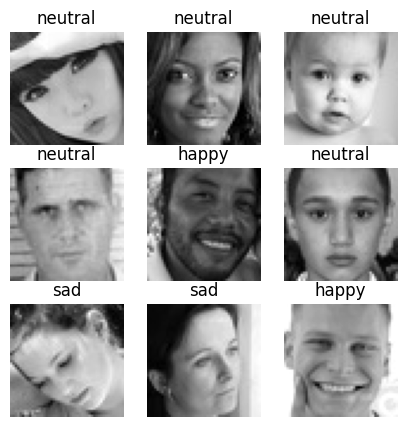

In [4]:
# Visualización de algunos datos del dataset
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
for images, labels in testData.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.axis("off")
    plt.title(labelNames[np.argmax(labels[i])])
    plt.imshow(images[i], cmap="gray")

In [5]:
#Creación de 2 versiones de modelos CNN para data con Augmentación
modeloCNN = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), strides=1, padding="same", activation='elu', input_shape=(48, 48, 1)),
  tf.keras.layers.Conv2D(64, (3,3), strides=1, padding="same", activation='elu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Conv2D(64, (3,3), strides=1, padding="same", activation='elu'),
  tf.keras.layers.Conv2D(128, (3,3), strides=1, padding="same", activation='elu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.3),
    
  tf.keras.layers.Conv2D(64, (3,3), strides=1, padding="same", activation='elu'),
  tf.keras.layers.Conv2D(128, (3,3), strides=1, padding="same", activation='elu'),
  tf.keras.layers.MaxPooling2D(2, 2),
    
  tf.keras.layers.Conv2D(128, (3,3), strides=1, padding="same", activation='elu'),
  tf.keras.layers.Conv2D(256, (3,3), strides=1, padding="same", activation='elu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.3),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='elu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation='elu'),
  tf.keras.layers.Dense(7, activation='softmax')
])

In [6]:
# Compilación de los nuevos modelos
modeloCNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     metrics=['accuracy'])

In [5]:
from tensorflow.keras.callbacks import TensorBoard

In [6]:
#Cargar la extension de tensorboard de colab
%load_ext tensorboard

In [ ]:
tensorboardCNN = TensorBoard(log_dir='logs/cnn')
with tf.device('/gpu:0'):
    modeloCNN.fit(trainData,
                  validation_data=validData,
                  epochs=60,
                  callbacks=[tensorboardCNN])

# Modelos con Augmentación de Datos

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
batchSize = 32

trainDataGen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=5,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  zoom_range=[1.0, 1.2],
                                  horizontal_flip=True,
                                  validation_split=0.2)

validDataGen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.2)

trainDataAug = trainDataGen.flow_from_directory(trainDirectory,
                                                target_size=(48,48),
                                                batch_size=batchSize,
                                                color_mode="grayscale",
                                                class_mode="categorical",
                                                seed=200,
                                                subset='training')

validDataAug = validDataGen.flow_from_directory(trainDirectory,
                                                target_size=(48,48),
                                                batch_size=batchSize,
                                                color_mode="grayscale",
                                                class_mode="categorical",
                                                shuffle=False,
                                                seed=200,
                                                subset="validation")

Found 22910 images belonging to 7 classes.
Found 5725 images belonging to 7 classes.


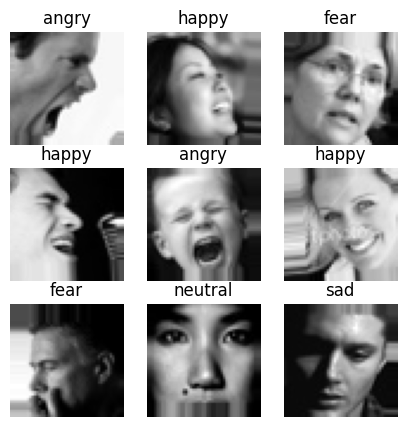

In [9]:
plt.figure(figsize=(5, 5))
images, labels = trainDataAug.__getitem__(1)

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.axis("off")
    plt.title(labelNames[int(np.argmax(labels[i]))])
    plt.imshow(images[i], cmap="gray")

In [10]:
#Creación de 2 versiones de modelos CNN para data con Augmentación
modeloAugCNN = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), padding="same", activation='relu', input_shape=(48, 48, 1)),
  tf.keras.layers.Conv2D(64, (3,3), padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.4),

  tf.keras.layers.Conv2D(64, (3,3), padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.4),

  tf.keras.layers.Conv2D(128, (3,3), padding="same", activation='relu'),
  tf.keras.layers.Conv2D(256, (3,3), padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.4),
                                  
  tf.keras.layers.Conv2D(256, (3,3), padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.4),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Dense(7, activation='softmax')
])

In [11]:
# Compilación de los nuevos modelos
modeloAugCNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])

In [12]:
tensorboardAugCNN = TensorBoard(log_dir='logs/cnnAug')
with tf.device('/gpu:0'):
    history = modeloAugCNN.fit(trainDataAug,
                     validation_data=validDataAug,
                     epochs=150,
                     batch_size=32,
                     steps_per_epoch=int(np.ceil(trainDataAug.n / float(32))),
                     validation_steps=int(np.ceil(validDataAug.n / float(32))),
                     callbacks=[tensorboardAugCNN])

Epoch 1/150
716/716 [==============================] - 18s 19ms/step - loss: 2.0860 - accuracy: 0.2268 - val_loss: 1.8258 - val_accuracy: 0.2533
Epoch 2/150
716/716 [==============================] - 13s 18ms/step - loss: 1.8695 - accuracy: 0.2645 - val_loss: 1.7535 - val_accuracy: 0.2997
Epoch 3/150
716/716 [==============================] - 13s 18ms/step - loss: 1.7323 - accuracy: 0.3298 - val_loss: 1.6063 - val_accuracy: 0.3976
Epoch 4/150
716/716 [==============================] - 13s 18ms/step - loss: 1.5882 - accuracy: 0.3950 - val_loss: 1.5474 - val_accuracy: 0.4267
Epoch 5/150
716/716 [==============================] - 13s 18ms/step - loss: 1.4719 - accuracy: 0.4376 - val_loss: 1.3847 - val_accuracy: 0.4650
Epoch 6/150
716/716 [==============================] - 13s 18ms/step - loss: 1.4128 - accuracy: 0.4610 - val_loss: 1.2908 - val_accuracy: 0.5006
Epoch 7/150
716/716 [==============================] - 13s 18ms/step - loss: 1.3664 - accuracy: 0.4811 - val_loss: 1.3157 - val_ac

716/716 [==============================] - 13s 18ms/step - loss: 0.9680 - accuracy: 0.6323 - val_loss: 1.0399 - val_accuracy: 0.6150
Epoch 58/150
716/716 [==============================] - 13s 18ms/step - loss: 0.9623 - accuracy: 0.6361 - val_loss: 1.1727 - val_accuracy: 0.5867
Epoch 59/150
716/716 [==============================] - 13s 18ms/step - loss: 0.9589 - accuracy: 0.6365 - val_loss: 0.9986 - val_accuracy: 0.6372
Epoch 60/150
716/716 [==============================] - 13s 18ms/step - loss: 0.9657 - accuracy: 0.6402 - val_loss: 0.9913 - val_accuracy: 0.6341
Epoch 61/150
716/716 [==============================] - 13s 18ms/step - loss: 0.9536 - accuracy: 0.6372 - val_loss: 0.9856 - val_accuracy: 0.6334
Epoch 62/150
716/716 [==============================] - 13s 18ms/step - loss: 0.9601 - accuracy: 0.6402 - val_loss: 1.0444 - val_accuracy: 0.6218
Epoch 63/150
716/716 [==============================] - 13s 18ms/step - loss: 0.9515 - accuracy: 0.6435 - val_loss: 1.0072 - val_accuracy

716/716 [==============================] - 13s 18ms/step - loss: 0.8499 - accuracy: 0.6819 - val_loss: 0.9809 - val_accuracy: 0.6472
Epoch 114/150
716/716 [==============================] - 13s 19ms/step - loss: 0.8563 - accuracy: 0.6814 - val_loss: 1.0336 - val_accuracy: 0.6262
Epoch 115/150
716/716 [==============================] - 13s 19ms/step - loss: 0.8404 - accuracy: 0.6843 - val_loss: 1.0136 - val_accuracy: 0.6398
Epoch 116/150
716/716 [==============================] - 13s 19ms/step - loss: 0.8462 - accuracy: 0.6854 - val_loss: 1.0059 - val_accuracy: 0.6477
Epoch 117/150
716/716 [==============================] - 14s 19ms/step - loss: 0.8396 - accuracy: 0.6823 - val_loss: 0.9832 - val_accuracy: 0.6498
Epoch 118/150
716/716 [==============================] - 14s 20ms/step - loss: 0.8464 - accuracy: 0.6799 - val_loss: 0.9928 - val_accuracy: 0.6486
Epoch 119/150
716/716 [==============================] - 14s 20ms/step - loss: 0.8436 - accuracy: 0.6838 - val_loss: 0.9962 - val_ac

In [13]:
modeloAugCNN.evaluate(testData)

224/224 [==============================] - 2s 7ms/step - loss: 0.9707 - accuracy: 0.6636


[0.9707316756248474, 0.6635957360267639]

In [56]:
modeloAugCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        3

# Plot accuracy

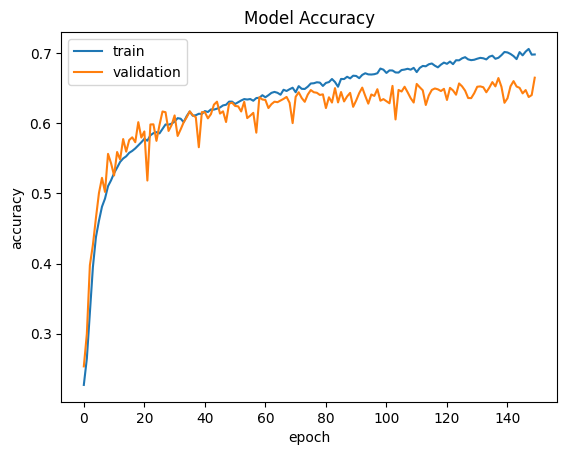

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Plot loss

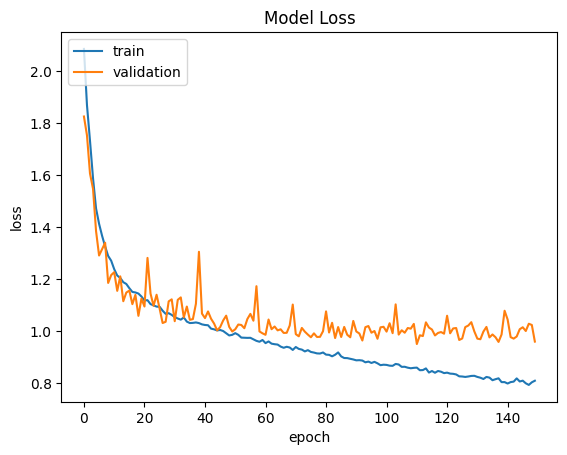

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Visualización de Tensorboard

In [18]:
#Ejecutar tensorboard e indicarle que lea la carpeta "logs"
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 21232), started 4:22:44 ago. (Use '!kill 21232' to kill it.)

# Guardado y Ejecución de Modelo TFLite

In [ ]:
# Crear una carpeta en caso se necesite
!mkdir saved_models

In [19]:
# Guardar un modelo .h5
tf.keras.models.save_model(modeloAugCNN, 'saved_models/modeloAugCNN.h5')

In [20]:
# Cargar un modelo .h5
model = tf.keras.models.load_model('saved_models/modeloAugCNN.h5')

In [21]:
# Convertir el modelo .h5 cargado a un modelo .tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('saved_models/model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Richard\AppData\Local\Temp\tmpzo066ixl\assets


INFO:tensorflow:Assets written to: C:\Users\Richard\AppData\Local\Temp\tmpzo066ixl\assets


In [49]:
import numpy as np

# Cargar una imagen de prueba para el modelo TFLite
image = tf.keras.utils.load_img("test_images/fear.jpg",
                                color_mode="grayscale")
imgArray = tf.keras.utils.img_to_array(image)
imgArray = np.array([imgArray])  # Convertirlo a np.array para predicción en el modelo
imgArray /= 255.                 # Normalizar los valores de la imagen entre 0 y 1

In [50]:
# Crear el interpretador del modelo y alocar los tensores
interpreter = tf.lite.Interpreter(model_path="saved_models/model.tflite")
interpreter.allocate_tensors()

# Obtener detalles del input y output del modelo
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Preparar el tensor de entrada con la imagen, invokar el modelo y obtener el tensor de salida
interpreter.set_tensor(input_details[0]['index'], imgArray)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])
print(output)

[[1.8163331e-04 4.5587590e-06 9.6530074e-01 2.1382555e-06 6.7415481e-06
  5.5580080e-05 3.4448605e-02]]


(-0.5, 47.5, 47.5, -0.5)

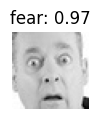

In [51]:
import matplotlib.pyplot as plt

imgArray = tf.keras.utils.img_to_array(image)
plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
plt.title(f'{labelNames[np.argmax(output[0])]}: {output[0][np.argmax(output[0])]:.2f}')
plt.axis("off")